Importing the required libraries:

In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import pickle
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## for machine learning

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking

## Preparing the sine wave function

In [2]:
x_axis = np.arange(-50*np.pi, 50*np.pi, 0.1)
y_axis = np.sin(x_axis)
df = pd.DataFrame({"x_axis": x_axis, "y_axis":y_axis})

df.head()

,x_axis,y_axis
0,-157.079633,-9.821934e-16
1,-156.979633,9.983342e-02
2,-156.879633,1.986693e-01
3,-156.779633,2.955202e-01
4,-156.679633,3.894183e-01


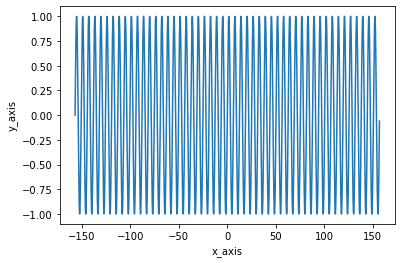

In [3]:
sns.lineplot(data=df, x="x_axis", y="y_axis");

In [4]:
df_eq_model = df.copy()

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(2827, 2) (315, 2)


In [5]:
train.head(2)

,x_axis,y_axis
0,-157.079633,-9.821934e-16
1,-156.979633,9.983342e-02


In [6]:
test.head(2)

,x_axis,y_axis
2827,125.620367,-0.043325
2828,125.720367,0.056631


In [7]:
from sklearn.preprocessing import RobustScaler

f_columns = ["x_axis"]

f_transformer = RobustScaler()
y_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
y_transformer = y_transformer.fit(train[["y_axis"]])

In [8]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [9]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["y_axis"] = y_transformer.transform(train[["y_axis"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["y_axis"] = y_transformer.transform(test[["y_axis"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Preparing the data for LSTM

In [10]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [11]:
TIME_STEPS = 60

X_train, y_train = create_dataset(train, train["y_axis"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["y_axis"], time_steps= TIME_STEPS)

In [12]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(2767, 60, 2) (2767,)
(255, 60, 2) (255,)


In [13]:
X_train[0][0]

array([-1.        , -0.00188615])

## Model Architecture

In [14]:

model = keras.Sequential()
# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [15]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [16]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.33, 
    shuffle = False # As it is time-series
)

Epoch 1/20
58/58 [==============================] - 2s 27ms/step - loss: 0.0329 - val_loss: 0.0081
Epoch 2/20
58/58 [==============================] - 1s 19ms/step - loss: 0.0053 - val_loss: 0.0027
Epoch 3/20
58/58 [==============================] - 1s 18ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 4/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0021 - val_loss: 8.0169e-04
Epoch 5/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0020 - val_loss: 5.4577e-04
Epoch 6/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0016 - val_loss: 4.7564e-04
Epoch 7/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 2.3497e-04
Epoch 8/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0015 - val_loss: 1.4283e-04
Epoch 9/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0013 - val_loss: 1.5688e-04
Epoch 10/20
58/58 [==============================] - 1s 17ms/step - loss: 0.0013 - va

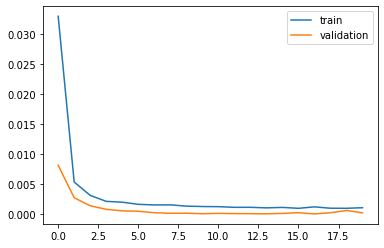

In [17]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()


In [18]:
y_pred = model.predict(X_test)

In [19]:
y_train_inv = y_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = y_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = y_transformer.inverse_transform(y_pred)

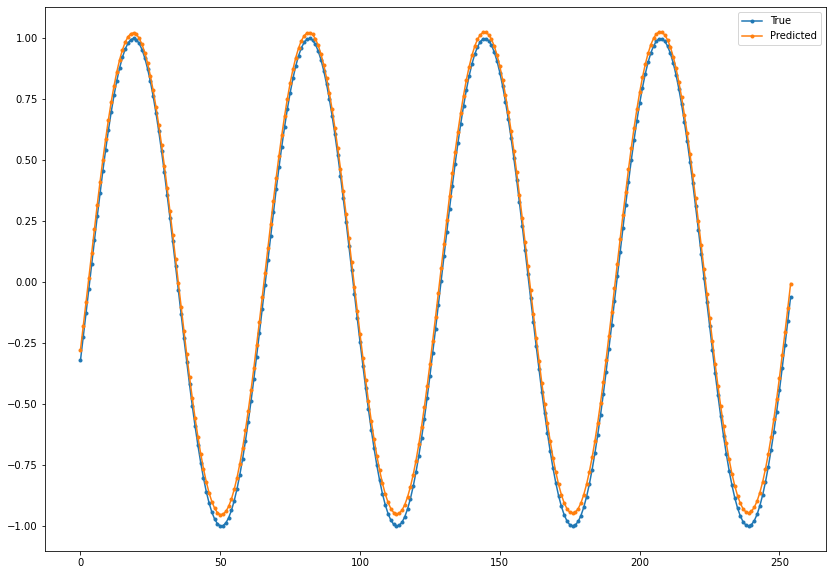

In [20]:
plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), marker = '.', label = "True")
plt.plot(y_pred_inv.flatten(), marker = '.', label = "Predicted")

plt.legend()

In [21]:
print("Hello World!")

Hello World!
